<a href="https://colab.research.google.com/github/rahiakela/mlops-research-and-practice/blob/main/machine-learning-for-streaming-data/05_imbalanced_class_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [ ]:
!pip install river

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import random

from river import anomaly

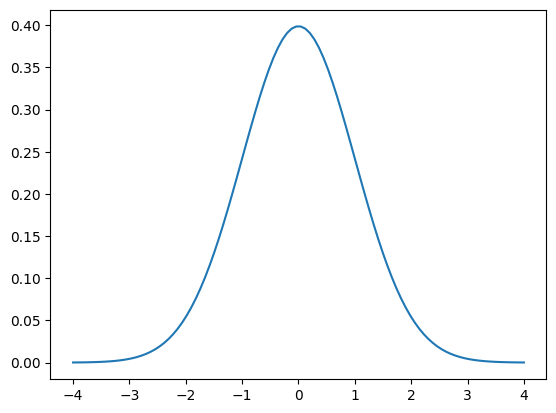

In [6]:
x = np.linspace(-4,4, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1))

(array([1.100000e+01, 7.700000e+01, 4.280000e+02, 2.230000e+03,
        9.912000e+03, 3.506700e+04, 1.051810e+05, 2.614270e+05,
        5.432390e+05, 9.427390e+05, 1.364606e+06, 1.649986e+06,
        1.660910e+06, 1.403348e+06, 9.858330e+05, 5.801330e+05,
        2.840080e+05, 1.162780e+05, 3.991700e+04, 1.141800e+04,
        2.651000e+03, 5.190000e+02, 7.000000e+01, 1.000000e+01,
        2.000000e+00]),
 array([-5.15802042, -4.72998373, -4.30194705, -3.87391037, -3.44587369,
        -3.017837  , -2.58980032, -2.16176364, -1.73372696, -1.30569027,
        -0.87765359, -0.44961691, -0.02158023,  0.40645645,  0.83449314,
         1.26252982,  1.6905665 ,  2.11860318,  2.54663987,  2.97467655,
         3.40271323,  3.83074991,  4.2587866 ,  4.68682328,  5.11485996,
         5.54289664]),
 <BarContainer object of 25 artists>)

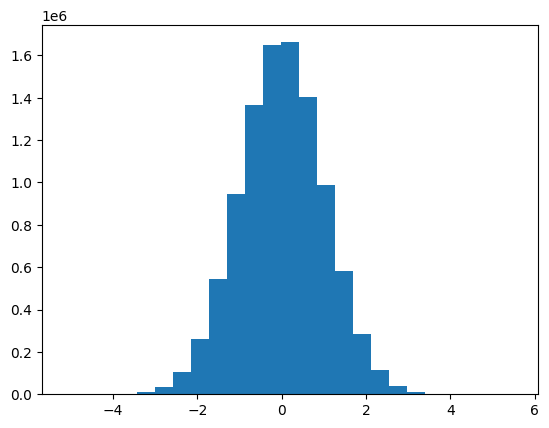

In [7]:
data = np.random.normal(size=10000000)
plt.hist(data, bins=25)

In [8]:
min(data), max(data)

(-5.158020415301046, 5.542896642454199)

##One-Class SVM

(array([ 93., 113.,  84., 110.,  94., 117.,  89., 101., 100.,  99.]),
 array([0.00290843, 0.10245779, 0.20200715, 0.30155651, 0.40110587,
        0.50065523, 0.60020459, 0.69975395, 0.79930331, 0.89885267,
        0.99840203]),
 <BarContainer object of 10 artists>)

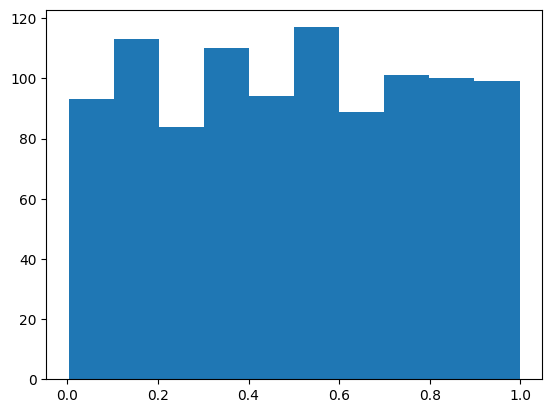

In [2]:
# Let's create a uniform distribution variable with 1,000 observations between 0 and 1
normal_data = np.random.rand(1000)

plt.hist(normal_data)

As we know, any data point between 0 and 1 is normal and every data point outside 0 to 1 is an outlier.

Let's now add 1% of outliers to the data. Let's make 0.5% of easy-to-detect outliers(random int between 2 and 3 and between -1 and -2), which is very far away from our normal distribution.

Let's also make 0.5% of our outliers a bit harder to detect
(between 0 and -1 and between 1 and 2).

In [3]:
hard_to_detect = list(np.random.uniform(1, 2, size=int(0.005 * 1000))) + list(np.random.uniform(1, -1, size=int(0.005 * 1000)))
easy_to_detect = list(np.random.uniform(2, 3, size=int(0.005 * 1000))) + list(np.random.uniform(-1, -2, size=int(0.005 * 1000)))

In [7]:
# Let's put all that data together and deliver it to the model in a streaming fashion
total_data = list(normal_data) + hard_to_detect + easy_to_detect

random.shuffle(total_data)

for dp in total_data:
  # Now, the only thing remaining to do is to add the model into the loop
  pass

In [4]:
# Anomaly percentage for the quantile thresholder
expected_percentage_anomaly = 20 / 1020
expected_percentage_normal = 1- expected_percentage_anomaly
expected_percentage_normal

0.9803921568627451

In [5]:
model = anomaly.QuantileFilter(anomaly.OneClassSVM(nu=0.2), q=expected_percentage_normal)
model

QuantileFilter (
  anomaly_detector=OneClassSVM (
    nu=0.2
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
  q=0.980392
  protect_anomaly_detector=True
)

In [8]:
for dp in total_data:
  model.learn_one({"x": dp})

In [9]:
# Let's try to get an idea of how well it worked.
scores = []
for dp in total_data:
  scores.append(model.score_one({"x": dp}))

In [10]:
# As we know the actual result, we can now compare whether the answers were right
results = pd.DataFrame({"data": total_data, "score": scores})
results["actual_outlier"] = (results["data"] > 1) | (results["data"] < 0)

# there are 18 actual outliers
results["actual_outlier"].value_counts()

actual_outlier
False    1004
True       16
Name: count, dtype: int64

In [11]:
# the algo detected 22 outliers
results["score"].value_counts()

score
0.052820    1
0.160916    1
0.026372    1
0.033468    1
0.090166    1
           ..
0.066752    1
0.112721    1
0.043708    1
0.008705    1
0.009376    1
Name: count, Length: 1020, dtype: int64

In [12]:
# We should now compute how many of the detected outliers are actual outliers and how many are not actual outliers.
results.groupby("actual_outlier")["score"].sum()  # in the 22 detected otuliuers, 10 are actual outliers, but 12 are not actually outliers

actual_outlier
False    57.143736
True      1.125344
Name: score, dtype: float64

##Half-Space-Trees

In [16]:
model2 = anomaly.QuantileFilter(anomaly.HalfSpaceTrees(), q=expected_percentage_normal)
model2

QuantileFilter (
  anomaly_detector=HalfSpaceTrees (
    n_trees=10
    height=8
    window_size=250
    limits=defaultdict(..., {})
    seed=None
  )
  q=0.980392
  protect_anomaly_detector=True
)

In [17]:
for dp in total_data:
  model2 = model2.learn_one({"x": dp})

AttributeError: 'NoneType' object has no attribute 'learn_one'

In [18]:
# Let's try to get an idea of how well it worked.
scores2 = []
for dp in total_data:
  scores2.append(model2.score_one({"x": dp}))

AttributeError: 'NoneType' object has no attribute 'score_one'